# Donor match

In this notebook, we show an example on how to align donors by their genotypes: 
1) between vireo and other 'omics data (e.g., SNP array, bulk RNA-seq, Exome-seq)
2) between multiple batches all estimated by vireo.

The idea is the same for the two cases: align the donors with giving least genotype difference, either using categorical genotype value or genotype probability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import vireoSNP
print("vireoSNP version: %s" %vireoSNP.__version__)

vireoSNP version: 0.5.6


## Option 1: using wrap function

The simple option is to use the wrap function `vireoSNP.vcf.match_VCF_samples`

In [2]:
res = vireoSNP.vcf.match_VCF_samples('../data/donors.cellSNP.vcf.gz', 
                                     '../data/outs/cellSNP_noGT/GT_donors.vireo.vcf.gz',
                                     GT_tag1 = 'PL', GT_tag2='PL')

Shape for Geno Prob in VCF1: (3784, 4, 3)
Shape for Geno Prob in VCF2: (3784, 4, 3)
n_variants in VCF1, VCF2 and matchd: 3784, 3784, 3784
aligned donors:
['MantonCB1' 'MantonCB2' 'MantonCB3' 'MantonCB4']
['donor2' 'donor1' 'donor3' 'donor0']


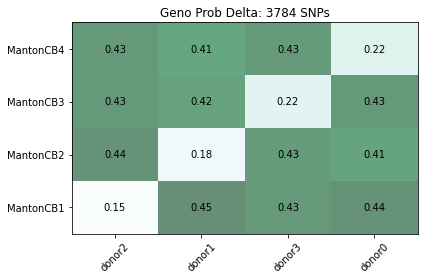

In [3]:
fig = plt.figure()
vireoSNP.plot.heat_matrix(res['matched_GPb_diff'], 
                          res['matched_donors1'] , 
                          res['matched_donors2'] )
plt.title("Geno Prob Delta: %d SNPs" %(res['matched_n_var']))
plt.tight_layout()
plt.show()

## Option 2: using element functions for customised analysis

Alternatively, you can use the build-in functions to perform each step, including [vireoSNP.load_VCF](https://github.com/single-cell-genetics/vireo/blob/master/vireoSNP/utils/vcf_utils.py#L68) to load VCF file and [vireoSNP.optimal_match](https://github.com/single-cell-genetics/vireo/blob/master/vireoSNP/utils/vireo_base.py#L143) to align donors that give minimal genotype differences by [Hungarian algorithm](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html).

### Prepare the data for this example

Make sure your run vireo on the example data already

```bash
cd ../
mkdir data/outs
vireo -c data/cellSNP_mat -N 4 -o data/outs/cellSNP_noGT --randSeed 2
```
so you will have the estimated donor genotype `../data/outs/cellSNP_noGT/GT_donors.vireo.vcf.gz`

Now, we will align the estimated donor genotype to another VCF estimated from bulk RNA-seq: `../data/donors.cellSNP.vcf.gz`

**Note:** Often the known donor genotype VCF file can be very big, make sure you filter out unwanted variants first, as vireoSNP.load_VCF is not as efficient as [bcftools]()

```bash
bcftools view donor.vcf.gz -R cellSNP.cells.vcf.gz -Oz -o sub.vcf.gz
```

Also, add -s or -S for subsetting samples.

### Load genotypes

#### Load genotype from external omics

In [4]:
GT_tag0 = 'PL' # common ones: GT, GP, PL
vcf_dat0 = vireoSNP.vcf.load_VCF("../data/donors.cellSNP.vcf.gz",
                                 biallelic_only=True, sparse=False, 
                                 format_list=[GT_tag0])

GPb0_var_ids = np.array(vcf_dat0['variants'])
GPb0_donor_ids = np.array(vcf_dat0['samples'])
GPb0_tensor = vireoSNP.vcf.parse_donor_GPb(vcf_dat0['GenoINFO'][GT_tag0], GT_tag0)
GPb0_tensor.shape

(3784, 4, 3)

In [5]:
print(GPb0_var_ids[:4])
print(GPb0_donor_ids)

['1_1065797_G_C' '1_1217251_C_A' '1_1230695_G_A' '1_1722625_A_T']
['MantonCB1' 'MantonCB2' 'MantonCB3' 'MantonCB4']


#### Load donor genotype from vireo

In [6]:
GT_tag1 = 'PL' # common ones: GT, GP, PL
vcf_dat1 = vireoSNP.vcf.load_VCF("../data/outs/cellSNP_noGT/GT_donors.vireo.vcf.gz",
                                 biallelic_only=True, sparse=False, 
                                 format_list=[GT_tag1])
GPb1_var_ids = np.array(vcf_dat1['variants'])
GPb1_donor_ids = np.array(vcf_dat1['samples'])
GPb1_tensor = vireoSNP.vcf.parse_donor_GPb(vcf_dat1['GenoINFO'][GT_tag1], GT_tag1)
GPb1_tensor.shape

(3784, 4, 3)

In [7]:
print(GPb1_var_ids[:4])
print(GPb1_donor_ids)

['1_1065797_G_C' '1_1217251_C_A' '1_1230695_G_A' '1_1722625_A_T']
['donor0' 'donor1' 'donor2' 'donor3']


#### Match variant ids in two VCF

In [8]:
mm_idx = vireoSNP.base.match(GPb1_var_ids, GPb0_var_ids)
mm_idx = mm_idx.astype(float)
idx1 = np.where(mm_idx == mm_idx)[0] #remove None for unmatched
idx2 = mm_idx[idx1].astype(int)

GPb1_var_ids_use = GPb1_var_ids[idx1]
GPb0_var_ids_use = GPb0_var_ids[idx2]

GPb1_tensor_use = GPb1_tensor[idx1]
GPb0_tensor_use = GPb0_tensor[idx2]

In [9]:
idx0, idx1, GPb_diff = vireoSNP.base.optimal_match(GPb0_tensor_use, GPb1_tensor_use, 
                                                   axis=1, return_delta=True)

In [10]:
print("aligned donors:")
print(GPb0_donor_ids[idx0])
print(GPb1_donor_ids[idx1])

aligned donors:
['MantonCB1' 'MantonCB2' 'MantonCB3' 'MantonCB4']
['donor2' 'donor1' 'donor3' 'donor0']


In [11]:
GPb_diff[idx0, idx1], GPb_diff[idx0, idx1].sum()

(array([0.14587886, 0.18311432, 0.21590132, 0.2242216 ]), 0.7691161042798316)

In [12]:
GPb_diff

array([[0.43953632, 0.44637255, 0.14587886, 0.43196454],
       [0.41237004, 0.18311432, 0.43762865, 0.42730004],
       [0.42995647, 0.41562163, 0.42928298, 0.21590132],
       [0.2242216 , 0.40922386, 0.43151424, 0.42764627]])

### Plot the genotype probability difference

Note, in this example data set the genotype estimation is not perfect as it is only based on ~250 cells in 10x data, namely not a decent coverage. Nevertheless, it is clear enough to find the donor identity.

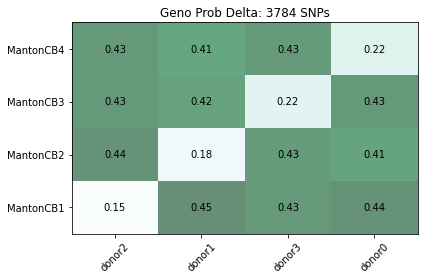

In [13]:
fig = plt.figure()
vireoSNP.plot.heat_matrix(GPb_diff[idx0, :][:, idx1], 
                          GPb0_donor_ids[idx0], 
                          GPb1_donor_ids[idx1])
plt.title("Geno Prob Delta: %d SNPs" %(len(GPb0_var_ids_use)))
plt.tight_layout()
plt.show()